In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

2024-12-20 00:13:46.730648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734675226.816976     385 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734675226.848878     385 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 00:13:47.076774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(42)

In [3]:
smoothed = 0

def pre_process_sample(spectrum):
    global smoothed
    def modified_z_score(ys):
        ysb = np.diff(ys) # Differentiated intensity values
        median_y = np.median(ysb) # Median of the intensity values
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
        return modified_z_scores
        
    # The next function calculates the average values around the point to be replaced.
    def fixer(y,ma):
        threshold = 7 # binarization threshold
        spikes = abs(np.array(modified_z_score(y))) > threshold
        y_out = y.copy()
        for i in np.arange(len(spikes)):
            if spikes[i] != 0:
                w = np.arange(i-ma,i+1+ma)
                we = w[spikes[w] == 0]
                y_out[i] = np.mean(y[we])
        return y_out

    despiked_spectrum = fixer(spectrum, ma=10)
    w, p = 9, 2

    smoothed_spectrum = savgol_filter(despiked_spectrum, w, polyorder = p, deriv=0)

    print(smoothed)
    smoothed += 1

    return np.array(smoothed_spectrum)

In [5]:
data = json.loads(open('data.json', 'r').read())

In [25]:
X = np.array(data['spectrums'])
y = np.array(data['concentrations'])

X.shape

(5000, 10000)

In [7]:
X = np.array(list(map(pre_process_sample, X)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [26]:
# Initialize the TensorFlow model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1])  # Output layer for 20 components
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model and save the training history
history = model.fit(X_train, y_train, epochs=400, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/400


/home/aniruth/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0697 - val_loss: 0.0235
Epoch 2/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116 - val_loss: 0.0151
Epoch 3/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0116
Epoch 4/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 5/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4149e-04 - val_loss: 0.0096
Epoch 6/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6399e-04 - val_loss: 0.0094
Epoch 7/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4943e-04 - val_loss: 0.0091
Epoch 8/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9410e-04 - val_loss: 0.0091
Epoch 9/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2040e-04 - val_loss: 0.0089
Epoch 10/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8984e-04 - val_loss: 0.0087
Epoch 11/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2824e-04 - val_loss: 0.0089
Epoch 12/400
100/100 ━━━━

In [27]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

mad = np.mean(np.abs(y_pred - y_test))

f"Mean Squared Error: {mse} | Mean Absolute Deviation: {mad}"

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


'Mean Squared Error: 0.00041517712963399784 | Mean Absolute Deviation: 0.016354409003788026'

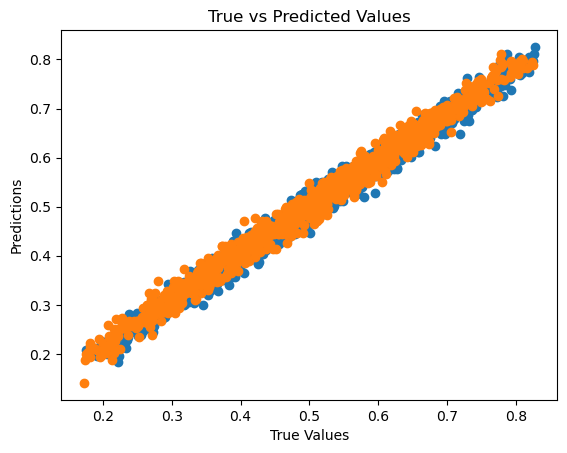

In [12]:
# Plot the results
plt.figure()
plt.plot(y_test, y_pred, 'o')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

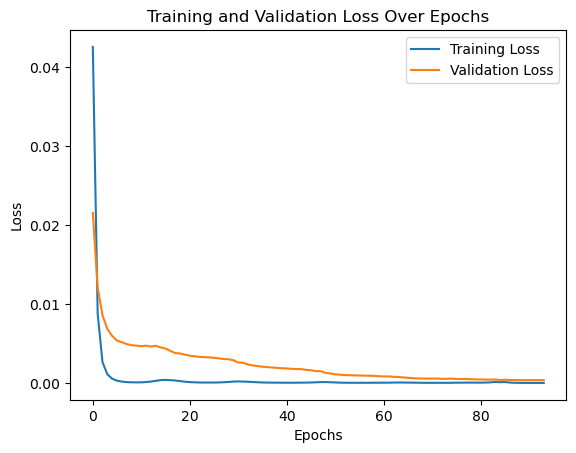

In [13]:
# Plot the training history
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [20]:
model.save('models/model.keras')